# ML CLASSIFICATION - {"RED WINE QUALITY" DATASET}

## 1. Importing Modules and Setting Configurations

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import StratifiedKFold, cross_val_score

from pickle import dump, load

import warnings
warnings.filterwarnings('ignore')

from sklearn import set_config
set_config(display='diagram')

In [2]:
# PD Options

pd.set_option('display.min_rows', 5)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 4)

# SB Options

sb.set_theme(context='notebook', style='whitegrid', palette='pastel', font='times new roman', font_scale=1.25)

## 2. Importing Dataset

### 2.1 Train Dataset

In [3]:
tr = pd.read_pickle('wine_quality_FE_final_train.pkl')

print(f'Shape of the train dataset : {tr.shape}')
tr.head(5)

Shape of the train dataset : (1230, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.5,0.510,0.15,3.0,0.064,12.0,27.0,0.9929,3.33,0.590,12.8,1
1,10.1,0.310,0.44,2.3,0.080,22.0,46.0,0.9988,3.32,0.670,9.7,1
2,10.5,0.510,0.64,2.4,0.107,6.0,15.0,0.9973,3.09,0.660,11.8,1
3,7.6,0.645,0.03,1.9,0.086,14.0,57.0,0.9969,3.37,0.460,10.3,0
4,10.7,0.670,0.22,2.7,0.107,17.0,34.0,1.0004,3.28,0.975,9.9,1


In [4]:
Xtr = tr.drop(columns='quality')
ytr = tr['quality']

### 2.2 Validation Dataset

In [5]:
val = pd.read_pickle('wine_quality_FE_final_valid.pkl')

print(f'Shape of the validation dataset : {val.shape}')
val.head(5)

Shape of the validation dataset : (100, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
905,10.2,0.29,0.65,2.4,0.075,6.0,17.0,0.9957,3.22,0.63,11.8,1
1336,5.6,0.31,0.78,13.9,0.074,23.0,92.0,0.9968,3.39,0.48,10.5,1
69,9.7,0.32,0.54,2.5,0.094,28.0,83.0,0.9984,3.28,0.82,9.6,0
933,8.6,0.52,0.38,1.5,0.096,5.0,18.0,0.9967,3.20,0.52,9.4,0
310,6.7,0.75,0.01,2.4,0.078,17.0,32.0,0.9955,3.55,0.61,12.8,1


In [6]:
Xval = val.drop(columns='quality')
yval = val['quality']

## 3. Pipeline Creation for Model Building

In [7]:
# Pre Processors

ct_preproc = ColumnTransformer([
    ('yj',PowerTransformer(method='yeo-johnson', standardize=False),slice(0,11)),
    ('ss',StandardScaler(),slice(0,11))
    ], remainder='passthrough')

In [8]:
# Feature Selection

skb = SelectKBest(mutual_info_classif, k='all')

In [9]:
# Estimator

#mdl = LogisticRegression(C=0.5, random_state=46)
mdl = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=46)

In [10]:
steps = [('ct_preproc',ct_preproc),
         ('skb',skb),
         ('mdl',mdl)]

In [11]:
pipe = Pipeline(steps)

## 4. Model Training

In [12]:
pipe.fit(Xtr,ytr)

Pipeline(steps=[('ct_preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('yj',
                                                  PowerTransformer(standardize=False),
                                                  slice(0, 11, None)),
                                                 ('ss', StandardScaler(),
                                                  slice(0, 11, None))])),
                ('skb',
                 SelectKBest(k='all',
                             score_func=<function mutual_info_classif at 0x000001FAAD874C10>)),
                ('mdl',
                 RandomForestClassifier(max_depth=3, n_estimators=200,
                                        random_state=46))])

## 5. Model Evaluation On Train and Test Data

In [13]:
yhat_tr = pipe.predict(Xtr)
yhat_val = pipe.predict(Xval)

print(f'Train Dataset Accuracy : {round(accuracy_score(ytr,yhat_tr)*100,4)} % \n')
print(f'Validation Dataset Accuracy : {round(accuracy_score(yval,yhat_val)*100,4)} %')

Train Dataset Accuracy : 77.3984 % 

Validation Dataset Accuracy : 76.0 %


In [14]:
print(classification_report(yval,yhat_val))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        48
           1       0.77      0.77      0.77        52

    accuracy                           0.76       100
   macro avg       0.76      0.76      0.76       100
weighted avg       0.76      0.76      0.76       100



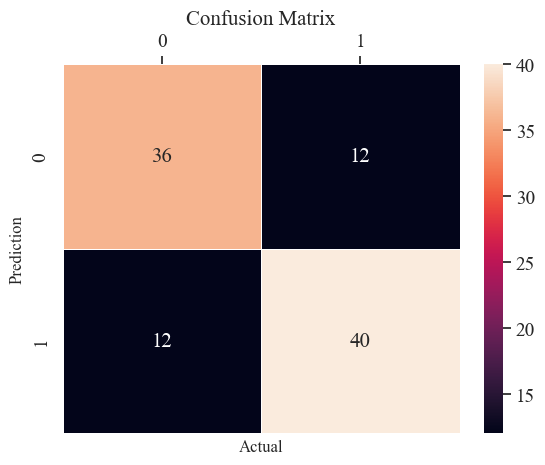

In [15]:
labels = yval.unique().tolist()
labels.sort()
#print(labels)

cm = confusion_matrix(yval,yhat_val)
#print(cm)

ax = sb.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels, linewidth=0.5)
ax.xaxis.tick_top()

plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=15)
plt.show()

## 6. Cross Validation

In [16]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=46)

cv_score = cross_val_score(pipe, Xtr, ytr, cv=kfold, scoring='accuracy').mean()
print(f'Cross Validation Score is : {round(cv_score*100,4)} %')

Cross Validation Score is : 76.2602 %


## 7. Model Save/Export

In [17]:
dump(pipe, open('wine_quality_mdl_fe_hyper.pkl','wb'))
print('Model Object Saved Successfully \n')

dump(Xtr, open('wine_quality_X_fe_hyper.pkl','wb'))
print('"Xtr" Features Saved Successfully')

Model Object Saved Successfully 

"Xtr" Features Saved Successfully


## 8. Simple Prediction System

### 8.1 Combining Xtest and ytest

In [18]:
samp = Xval.sample(10).index.values.tolist()
samp

[625, 1080, 1243, 857, 476, 1341, 190, 377, 905, 1063]

In [19]:
val_df = pd.concat([Xval.loc[samp],yval.loc[samp]],axis=1)
val_df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
625,7.6,0.420,0.08,2.7,0.084,15.0,48.0,0.9968,3.21,0.59,10.0,0
1080,6.9,0.410,0.31,2.0,0.079,21.0,51.0,0.9967,3.47,0.55,9.5,1
1243,7.3,0.480,0.32,2.1,0.062,31.0,54.0,0.9973,3.30,0.65,10.0,1
857,8.9,0.350,0.40,3.6,0.110,12.0,24.0,0.9955,3.23,0.70,12.0,1
476,10.6,0.310,0.49,2.5,0.067,6.0,21.0,0.9987,3.26,0.86,10.7,1
1341,6.2,0.560,0.09,1.7,0.053,24.0,32.0,0.9940,3.54,0.60,11.3,0
190,7.8,0.735,0.08,2.4,0.092,10.0,41.0,0.9974,3.24,0.71,9.8,1
377,11.9,0.370,0.69,2.3,0.078,12.0,24.0,0.9958,3.00,0.65,12.8,1
905,10.2,0.290,0.65,2.4,0.075,6.0,17.0,0.9957,3.22,0.63,11.8,1
1063,6.9,0.410,0.33,2.2,0.081,22.0,36.0,0.9949,3.41,0.75,11.1,1


### 8.2 Prediction on Validation Data

In [20]:
#inp_data = (13.7,0.415,0.68,2.9,0.085,17.0,43.0,1.0014,3.06,0.80,10.0)
#inp_data = np.array(inp_data).reshape(1,-1)

idx = val_df.sample().index.values
inp_data = Xval.loc[idx].values 

print(f'Test Data with Index : {idx[0]} is Selected for Prediction: \n')

for fea_name, fea_val in zip(Xval.columns.tolist(), inp_data[0]):
    print(f'"{fea_name}" ---:--- {fea_val}')

Test Data with Index : 625 is Selected for Prediction: 

"fixed acidity" ---:--- 7.6
"volatile acidity" ---:--- 0.42
"citric acid" ---:--- 0.08
"residual sugar" ---:--- 2.7
"chlorides" ---:--- 0.084
"free sulfur dioxide" ---:--- 15.0
"total sulfur dioxide" ---:--- 48.0
"density" ---:--- 0.9968
"pH" ---:--- 3.21
"sulphates" ---:--- 0.59
"alcohol" ---:--- 10.0


In [21]:
print(f'------------- Prediction for Validation Data with Index : {idx[0]} --------------------\n')

print(f'Actual Wine Quality for the Selected Data : {yval[idx[0]]} \n')

pipe = load(open('wine_quality_mdl_fe_hyper.pkl','rb'))
pred = pipe.predict(inp_data)

if (pred[0] == 1):
    print(f'Predicted Wine Quality : {pred[0]} (High Quality Wine)')
else:
    print(f'Predicted Wine Quality : {pred[0]} (Low Quality Wine)')

------------- Prediction for Validation Data with Index : 625 --------------------

Actual Wine Quality for the Selected Data : 0 

Predicted Wine Quality : 0 (Low Quality Wine)
